# Clustering-Based Course Recommender Systems

Import Libraries

In [1]:
# ------------- General ------------- #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Clustering-Based Recommender ------------- #
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

rs = 123

In [2]:
profile_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_profile.csv"
profile_df = pd.read_csv(profile_genre_url)

# user profiles
user_profile_df = profile_df

# Displaying the first few rows of the DataFrame to inspect its contents
user_profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


In [3]:
user_profile_df.shape

(33901, 15)

Check Course Genres

In [4]:
feature_names = list(user_profile_df.columns[1:])
feature_names

['Database',
 'Python',
 'CloudComputing',
 'DataAnalysis',
 'Containers',
 'MachineLearning',
 'ComputerVision',
 'DataScience',
 'BigData',
 'Chatbot',
 'R',
 'BackendDev',
 'FrontendDev',
 'Blockchain']

Summary of the Data

In [5]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000
mean,1.064064e+06,5.518569,3.493791,2.307100,3.624701,0.998938,3.048022,0.001770,5.087343,4.750450,0.462995,1.017433,2.269461,0.315802,0.986844
std,4.972578e+05,7.611941,4.227254,3.841858,4.760135,2.351764,4.624004,0.072846,5.230697,7.216228,1.055186,2.342532,4.310752,1.363462,1.950585
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.813480e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.043907e+06,3.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.451159e+06,9.000000,6.000000,3.000000,6.000000,0.000000,3.000000,0.000000,9.000000,6.000000,0.000000,0.000000,3.000000,0.000000,2.000000
max,2.103039e+06,63.000000,18.000000,38.000000,48.000000,15.000000,39.000000,3.000000,32.000000,54.000000,6.000000,18.000000,54.000000,15.000000,12.000000


The values should be standardised for better clustering results

In [6]:
# Use StandardScaler to make each feature with mean 0, standard deviation 1
# Instantiating a StandardScaler object
scaler = StandardScaler()

# Standardizing the selected features (feature_names) in the user_profile_df DataFrame
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])

user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04
mean,1.064064e+06,-3.353495e-17,-5.700942e-17,-3.521170e-17,-7.671120e-17,3.353495e-18,3.688845e-17,-1.509073e-17,-1.676748e-17,6.706990e-17,-6.874665e-17,4.233788e-17,1.383317e-17,5.051202e-17,-5.281755e-17
std,4.972578e+05,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,2.000000e+00,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
25%,6.813480e+05,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
50%,1.043907e+06,-3.308757e-01,-1.168130e-01,-6.005256e-01,-1.312380e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-3.990622e-01,-3.811535e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
75%,1.451159e+06,4.573712e-01,5.928781e-01,1.803581e-01,4.990056e-01,-4.247674e-01,-1.038556e-02,-2.429612e-02,7.480294e-01,1.731609e-01,-4.387873e-01,-4.343370e-01,1.694715e-01,-2.316212e-01,5.194189e-01
max,2.103039e+06,7.551593e+00,3.431642e+00,9.290667e+00,9.322416e+00,5.953517e+00,7.775190e+00,4.115884e+01,5.145214e+00,6.824934e+00,5.247500e+00,7.249771e+00,1.200053e+01,1.076995e+01,5.646161e+00


In [7]:
# features only df
features = user_profile_df.loc[:, user_profile_df.columns != 'user']
features

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,-0.330876,-0.116813,0.180358,0.499006,-0.424767,-0.659184,-0.024296,0.174484,-0.658311,-0.438787,2.127032,0.865416,-0.231621,1.032093
33897,-0.724999,-0.826504,-0.079936,-0.761482,-0.424767,-0.659184,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
33898,-0.330876,0.592878,0.961242,-0.761482,-0.424767,2.368540,-0.024296,0.748029,-0.658311,-0.438787,0.846348,-0.526473,-0.231621,-0.505930
33899,-0.724999,-0.826504,-0.600526,-0.761482,-0.424767,-0.226652,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930


In [8]:
# user ids
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']
user_ids.head()

,user
0,2
1,4
2,5
3,7
4,8


### K-Means Clustering
Unsupervised technique of vector quantization where the distances between data points and the centroid of its cluster are minimized.

In [9]:
# list of inertias for elbow method
inertias = []

# loop over 2-30
for k in range(2, 30):
    # create model
    kmeans = KMeans(random_state=rs, n_clusters=k, init="k-means++", n_init=10)
    kmeans.fit(features)
    inertias.append(kmeans.inertia_)

[]

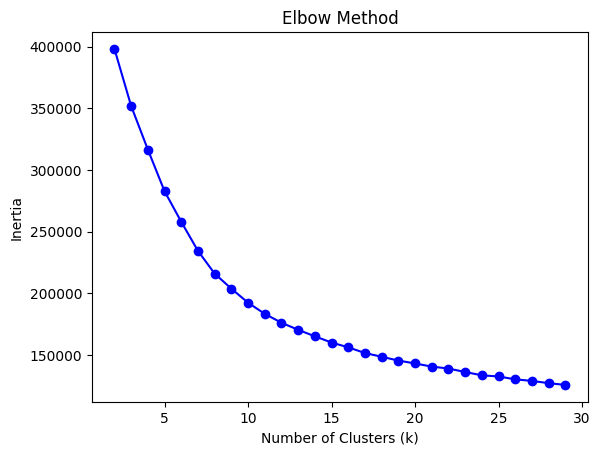

In [10]:
# plot elbow curve
plt.plot(range(2, 30), inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.plot()

20 Clusters Would Probably Be Fine Here

In [11]:
cluster_labels = [None] * len(user_ids)

In [12]:
# create final kmeans model
kmeans_final = KMeans(n_clusters=20, random_state=rs, init="k-means++", n_init=20, ).fit(features)

In [13]:
def combine_cluster_labels(user_ids, labels):
    # Convert labels to a DataFrame
    labels_df = pd.DataFrame(labels)    
    # Merge user_ids DataFrame with labels DataFrame based on index
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    # Rename columns to 'user' and 'cluster'
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

In [14]:
k_means_df = combine_cluster_labels(user_ids, kmeans_final.labels_)
k_means_df.head()

,user,cluster
0,2,14
1,4,17
2,5,14
3,7,18
4,8,18


#### Reducing Dimensions with PCA

In [15]:
print(f"There are {len(feature_names)} features for each user profile.")

There are 14 features for each user profile.


Plotting Correlation Matrix

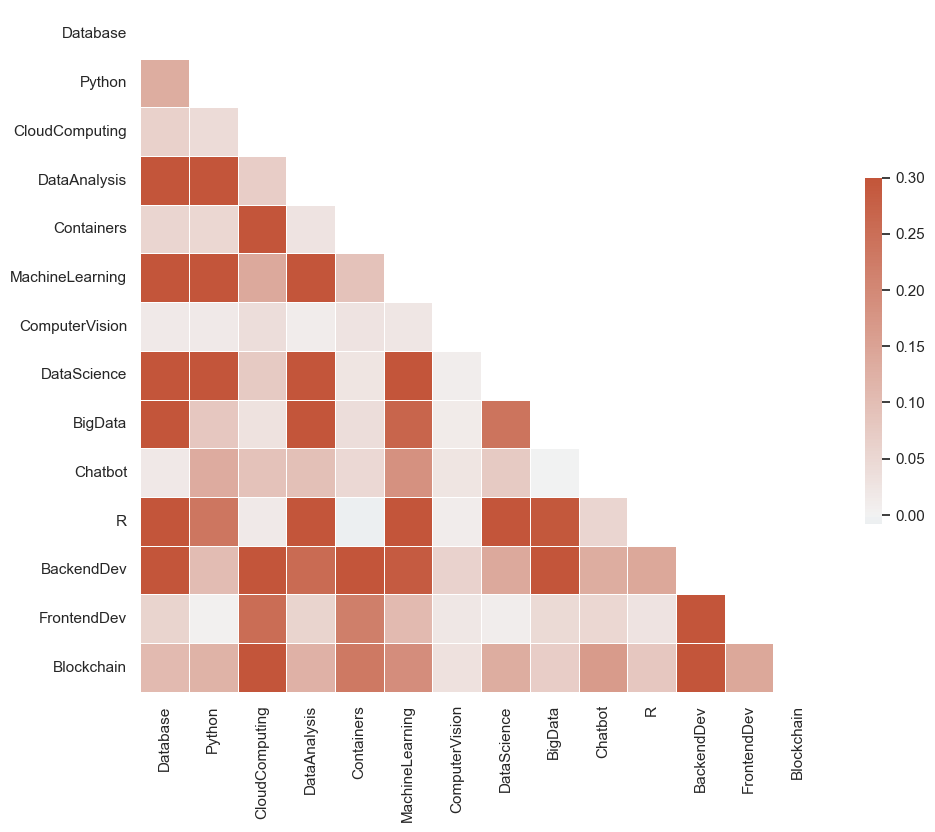

In [16]:
sns.set_theme(style="white")

# correlation matrix
corr = features.cov()

# triangle mask
mask = np.triu(np.ones_like(corr, dtype=bool))


f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

Finding Best PCA Components Number

Ideally, we want at least 9 components and want to maintain at least 90% of the variance.

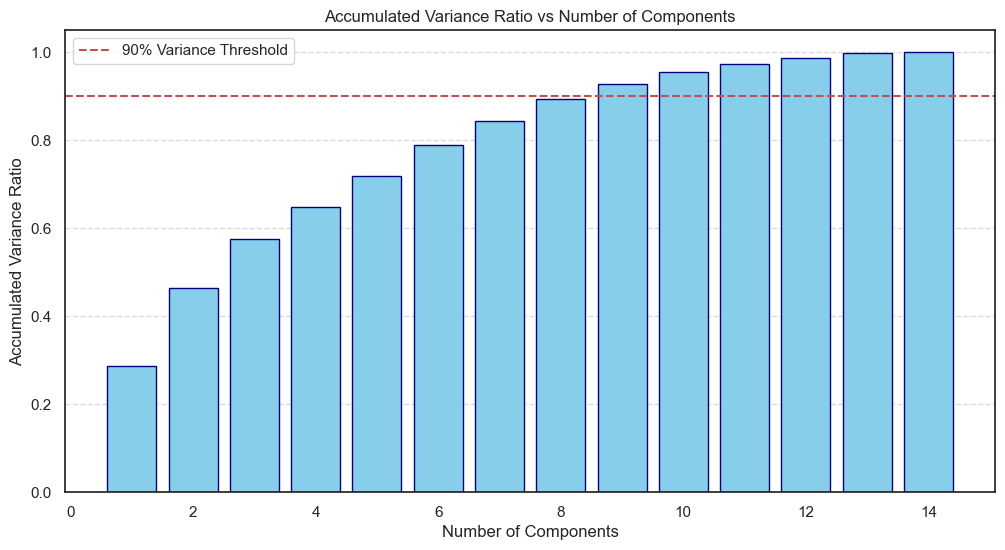

In [17]:
# possible components numbers
candidate_components = list(range(1, 15))

# variances
accumulated_variances = []

# compute PCA
for n_components in candidate_components:
    # pca model
    pca = PCA(n_components=n_components)
    
    # fit
    pca.fit(features)
    
    # get variances
    accumulated_variance = np.sum(pca.explained_variance_ratio_)
    accumulated_variances.append(accumulated_variance)

# Visualization with bar plots
plt.figure(figsize=(12, 6))

# Bar plot of accumulated variance
plt.bar(candidate_components, accumulated_variances, color='skyblue', edgecolor='navy')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.title('Accumulated Variance Ratio vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accumulated Variance Ratio')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Using 9 Components For PCA

In [18]:
pca_final = PCA(n_components=9)
pca_features = pca_final.fit_transform(features)

pca_features_df = pd.DataFrame(
    data=pca_features, 
    columns=[f'PC{i+1}' for i in range(pca_features.shape[1])]
)

# create pca features and user ids df (resetting index)
pca_features_df = pca_features_df.reset_index(drop=True)
user_ids = user_ids.reset_index(drop=True)

# merge dfs
pca_features_merged = pd.merge(
    user_ids, 
    pca_features_df, 
    left_index=True, 
    right_index=True
)

pca_features_merged.head()

,user,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,2,17.772494,0.200681,1.730609,2.567359,-3.825814,-2.707154,0.681042,2.312613,0.868272
1,4,7.145199,-2.847481,2.358636,-0.576654,0.398803,0.134533,0.549769,0.469033,0.033405
2,5,11.363270,1.873619,-1.522077,1.076144,-1.711688,-0.883212,1.677582,2.937669,2.097639
3,7,-1.834033,-0.277462,0.564905,0.053470,-0.064440,-0.165757,0.030956,0.039519,0.210887
4,8,-1.049125,-0.684767,1.072765,0.006371,-0.005695,-0.118686,0.118559,0.559292,0.186379


In [19]:
kmeans = KMeans(
    n_clusters=20,  # Use best number of clusters from previous grid search
    random_state=rs,
    n_init=20,
    init="k-means++"
)

# fit and get labels
cluster_labels = kmeans.fit_predict(pca_features)

# create df
clustered_users = pd.DataFrame({
    'user': user_ids.squeeze(),
    'cluster': cluster_labels
})

clustered_users.head()

,user,cluster
0,2,15
1,4,15
2,5,5
3,7,0
4,8,6


#### Generating Course Recommendations Using Clusters


In [20]:
test_users_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"

test_users_df = pd.read_csv(test_users_url)[['user', 'item']]

test_users_df.head()

,user,item
0,1889878,CC0101EN
1,1342067,CL0101EN
2,1990814,ML0120ENv3
3,380098,BD0211EN
4,779563,DS0101EN


In [21]:
test_users_labelled = pd.merge(test_users_df, clustered_users, left_on='user', right_on='user')
test_users_labelled.sort_values("user").head()

,user,item,cluster
141436,2,DP0101EN,15
81131,2,TMP0106,15
61727,2,BD0141EN,15
156548,2,BD0131EN,15
5402,2,LB0105ENv1,15


See What Classes Enrollments Each Cluster Has

In [22]:
courses_cluster = test_users_labelled[['item', 'cluster']]

courses_cluster['count'] = [1] * len(courses_cluster)

courses_cluster_grouped = courses_cluster.groupby(['cluster','item']).agg(enrollments=('count','sum')).reset_index()

courses_cluster_grouped.head(10)

,cluster,item,enrollments
0,0,AI0111EN,7
1,0,BC0201EN,947
2,0,BD0101EN,547
3,0,BD0111EN,197
4,0,BD0115EN,27
5,0,BD0121EN,7
6,0,BD0123EN,4
7,0,BD0131EN,10
8,0,BD0133EN,27
9,0,BD0135EN,7


Create Cluster-Based Recommendations

In [23]:
def cluster_based_recommendations(test_users_labelled, courses_cluster_grouped, enrollment_threshold=10):
    # create rec dict
    recommendations = {}
    
    # go through users
    for user in test_users_labelled['user'].unique():
        # get user cluster
        user_cluster = test_users_labelled[test_users_labelled['user'] == user]['cluster'].values[0]
        
        # get popular courses in cluster
        popular_cluster_courses = courses_cluster_grouped[
            (courses_cluster_grouped['cluster'] == user_cluster) & 
            (courses_cluster_grouped['enrollments'] >= enrollment_threshold)
        ]['item'].tolist()
        
        # get already enrolled course
        user_current_courses = test_users_labelled[
            test_users_labelled['user'] == user
        ]['item'].tolist()
        
        # get unseen courses
        unseen_popular_courses = [
            course for course in popular_cluster_courses 
            if course not in user_current_courses
        ]
        
        # store recs
        recommendations[user] = unseen_popular_courses
    
    return recommendations

# create recs
recommendations = cluster_based_recommendations(
    test_users_labelled, 
    courses_cluster_grouped, 
    enrollment_threshold=10
)

# create recs df
recommendations_data = []
for user, courses in recommendations.items():
    recommendations_data.append({
        'user': user,
        'recommended_courses': courses
    })

recommendations_df = pd.DataFrame(recommendations_data)

# display
recommendations_df.head()

,user,recommended_courses
0,1889878,"[BD0111EN, BD0115EN, BD0121EN, BD0123EN, BD013..."
1,1342067,"[BC0101EN, BC0202EN, BD0115EN, BD0121EN, BD012..."
2,1990814,"[AI0111EN, BC0101EN, BC0201EN, BC0202EN, BD012..."
3,380098,"[BC0201EN, BC0202EN, BD0101EN, BD0111EN, BD011..."
4,779563,"[AI0111EN, BC0201EN, BC0202EN, BD0111EN, BD011..."


Changing COURSE_ID to the name of the courses

In [24]:
course_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_genre.csv"
course_df = pd.read_csv(course_genre_url)

# Merge recommendations
recommendations_df = recommendations_df.explode('recommended_courses')

# Merge with course df
recommendations_df = recommendations_df.merge(
    course_df[['COURSE_ID', 'TITLE']], 
    left_on='recommended_courses', 
    right_on='COURSE_ID', 
    how='left'
)

# Group back to list format, keeping both course ID and title
recommendations_df = recommendations_df.groupby('user').agg({
    'COURSE_ID': lambda x: list(x),
    'TITLE': lambda x: list(x)
}).reset_index()

# Rename columns
recommendations_df.columns = ['user', 'recommended_course_ids', 'recommended_courses']

# Display results
recommendations_df.head()

,user,recommended_course_ids,recommended_courses
0,2,"[AI0111EN, BC0201EN, BC0202EN, BD0115EN, CB010...",[game playing ai with swift for tensorflow s4...
1,4,"[AI0111EN, BC0101EN, BC0201EN, BC0202EN, BD013...",[game playing ai with swift for tensorflow s4...
2,5,"[BC0202EN, BD0111EN, BD0115EN, BD0121EN, BD013...",[build an iot blockchain network for a supply ...
3,7,"[BC0201EN, BD0101EN, BD0111EN, BD0115EN, BD013...","[ibm blockchain foundation developer, big data..."
4,8,"[AI0111EN, BD0101EN, BD0115EN, BD0121EN, BD012...",[game playing ai with swift for tensorflow s4...


### DBSCAN & Hierarchal Agglomerative Clustering (HAC)
DBSCAN and Hierarchal Clustering are two different clustering techniques which will also be implemented. DBSCAN uses the desnity of the clusters in order to group points together. HAC uses different distance measurements to join nearby points together.

##### DBSCAN

DBSCAN has two inputs, epsilon and min_samples, both have to be tweaked to find your desired result. DBSCAN finds the number of clusters by itself, and even classifies outliers. However, outliers are not that important to our goal as we are trying to group people within clusters, and outliers would have no clusters to get recommendations from. Since this is just an investigation, DBSCAN will still be used just to compare.

In [25]:
# get silhouette score of model
def silhouette_scorer(estimator, X):
    try:
        # pred
        labels = estimator.fit_predict(X)
        
        # check for more than 1 cluster
        if len(np.unique(labels)) > 1:
            return silhouette_score(X, labels)
        else:
            return -1  
    except Exception as e:
        print(f"Scoring error: {e}")
        return -1


# param grid
param_grid = {
    'min_samples': range(15, 20),   
}

# dbscan
dbscan = DBSCAN(eps=2)



# grid search
grid_search_dbscan = RandomizedSearchCV(
    dbscan, 
    param_grid, 
    scoring=silhouette_scorer,
    cv=3,  
    n_iter=25,
    n_jobs=4,
    verbose=1
)

# fit (5mins ish)
grid_search_dbscan.fit(features)

# best params and score
best_params = grid_search_dbscan.best_params_
best_score = grid_search_dbscan.best_score_

print("Best DBSCAN Parameters:")
print(best_params)
print(f"Best Silhouette Score: {best_score}")

# best estimator
best_dbscan = grid_search_dbscan.best_estimator_

# predict user labels
labels_dbscan = best_dbscan.fit_predict(features)

c:\Users\Gustavo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=25. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best DBSCAN Parameters:
{'min_samples': 15}
Best Silhouette Score: 0.29587941027457665


##### HAC

For HAC, three different combinations of linkages and affinities will be used. Ward-Euclidean, Complete-Cosine, Average-Manhattan. HAC does not find the number of clusters by itself, so that will be found using the grid search.

Ward-Euclidean

In [26]:
best_score = -1
best_params = None
best_model = None

for n_clusters in range(10, 30):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', metric='euclidean')
    labels = model.fit_predict(features)
    score = silhouette_score(features, labels)
    
    if score > best_score:
        best_score = score
        best_params = {'n_clusters': n_clusters}
        best_model = model

best_params_we = best_params
best_score_we = best_score
best_model_we = best_model
print("Best Params:", best_params)
print("Best Score:", best_score)

# 13 mins ish


Best Params: {'n_clusters': 28}
Best Score: 0.22508366874723126


Complete-Cosine

In [27]:
best_score = -1
best_params = None
best_model = None

for n_clusters in range(10, 30):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', metric='cosine')
    labels = model.fit_predict(features)
    score = silhouette_score(features, labels)
    
    if score > best_score:
        best_score = score
        best_params = {'n_clusters': n_clusters}
        best_model = model

best_params_cc = best_params
best_score_cc = best_score
best_model_cc = best_model
print("Best Params:", best_params)
print("Best Score:", best_score)

# 12 mins ish


Best Params: {'n_clusters': 15}
Best Score: 0.18680322788513534


Average-Manhattan

In [28]:
best_score = -1
best_params = None
best_model = None

for n_clusters in range(10, 30):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', metric='manhattan')
    labels = model.fit_predict(features)
    score = silhouette_score(features, labels)
    
    if score > best_score:
        best_score = score
        best_params = {'n_clusters': n_clusters}
        best_model = model

best_params_am = best_params
best_score_am = best_score
best_model_am = best_model
print("Best Params:", best_params)
print("Best Score:", best_score)


Best Params: {'n_clusters': 10}
Best Score: 0.577035841808149


##### Comparing Clustering Methods

In [29]:
def compare_clustering_models(features, models, model_names):
    # labels
    labels_dict = {}
    
    # results
    comparison_results = []
    
    # calculate metrics
    for model, name in zip(models, model_names):
        try:
            # get labels from clusters (fit only once)
            labels = model.fit_predict(features)
            labels_dict[name] = labels
            
            # calculate metrics
            metrics = {
                'Model': name,
                'Number of Clusters': len(np.unique(labels)),
                'Silhouette Score': silhouette_score(features, labels),
                'Calinski-Harabasz Index': calinski_harabasz_score(features, labels),
                'Davies-Bouldin Index': davies_bouldin_score(features, labels)
            }
            
            comparison_results.append(metrics)
        
        except Exception as e:
            print(f"Error processing {name}: {e}")
    
    # create df
    comparison_df = pd.DataFrame(comparison_results)
    
    # plot
    plt.figure(figsize=(15, 5))
    
    # plot silhouette
    plt.subplot(131)
    comparison_df.plot(x='Model', y='Silhouette Score', kind='bar', ax=plt.gca())
    plt.title('Silhouette Scores')
    plt.xticks(rotation=45)
    
    # plot number of clusters
    plt.subplot(132)
    comparison_df.plot(x='Model', y='Number of Clusters', kind='bar', ax=plt.gca())
    plt.title('Number of Clusters')
    plt.xticks(rotation=45)
    
    # plot calinski
    plt.subplot(133)
    comparison_df.plot(x='Model', y='Calinski-Harabasz Index', kind='bar', ax=plt.gca())
    plt.title('Calinski-Harabasz Index')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # print comparison table
    print("\nClustering Model Comparison:")
    print(comparison_df.to_string(index=False))
    
    # visualise clusters
    plt.figure(figsize=(15, 5))
    
    for i, (model, name) in enumerate(zip(models, model_names), 1):
        plt.subplot(1, len(models), i)
        labels = labels_dict[name]
        unique, counts = np.unique(labels, return_counts=True)
        plt.bar(unique, counts)
        plt.title(f'Cluster Distribution - {name}')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Samples')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df, labels_dict

def detailed_clustering_analysis(features, models, model_names):
    # compare and get labels
    comparison_df, labels_dict = compare_clustering_models(
        features, models, model_names
    )
        
    # PCA for 2D
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)
    
    # plot 2D clusters
    plt.figure(figsize=(20, 5)) 
    
    for i, (model, name) in enumerate(zip(models, model_names), 1):
        plt.subplot(1, len(models), i)
        labels = labels_dict[name]
        
        # plot scatter
        scatter = plt.scatter(
            features_2d[:, 0], 
            features_2d[:, 1], 
            c=labels, 
            cmap='viridis',
            alpha=0.7,  
            s=10  
        )
        plt.title(name, fontsize=10, pad=10) 
        plt.xlabel('PC1', fontsize=8)
        plt.ylabel('PC2', fontsize=8)
        plt.colorbar(scatter, shrink=0.8)  
        plt.tight_layout()
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

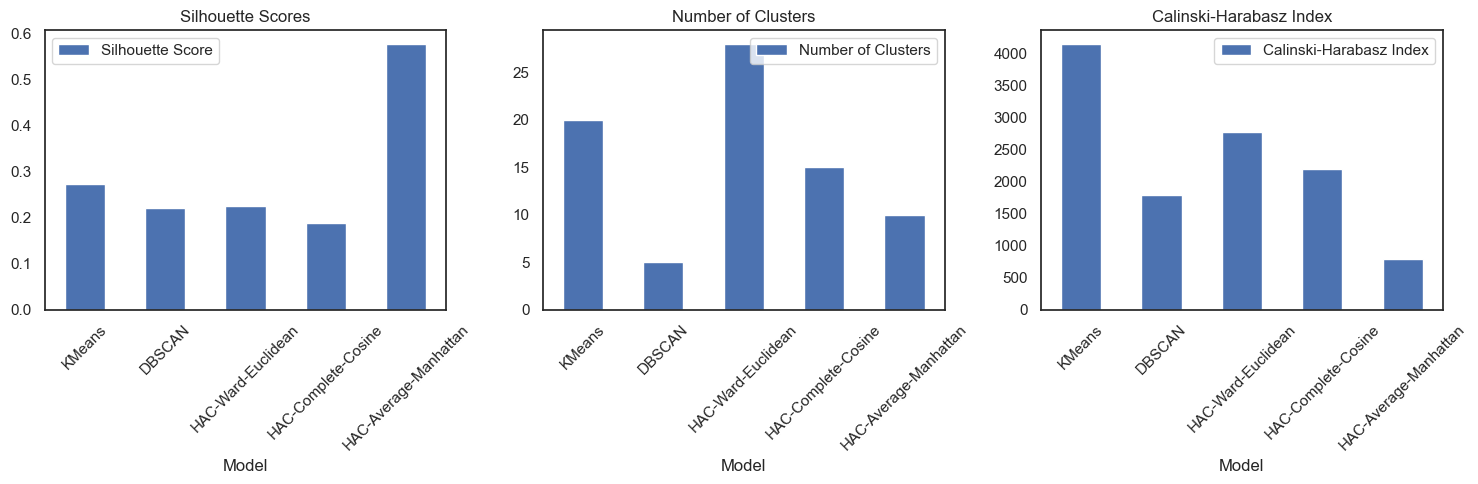


Clustering Model Comparison:
                Model  Number of Clusters  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
               KMeans                  20          0.272050              4159.791551              1.531302
               DBSCAN                   5          0.221238              1798.678845              1.513762
   HAC-Ward-Euclidean                  28          0.225084              2779.051482              1.699835
  HAC-Complete-Cosine                  15          0.186803              2206.003037              2.033161
HAC-Average-Manhattan                  10          0.577036               796.655311              1.276104


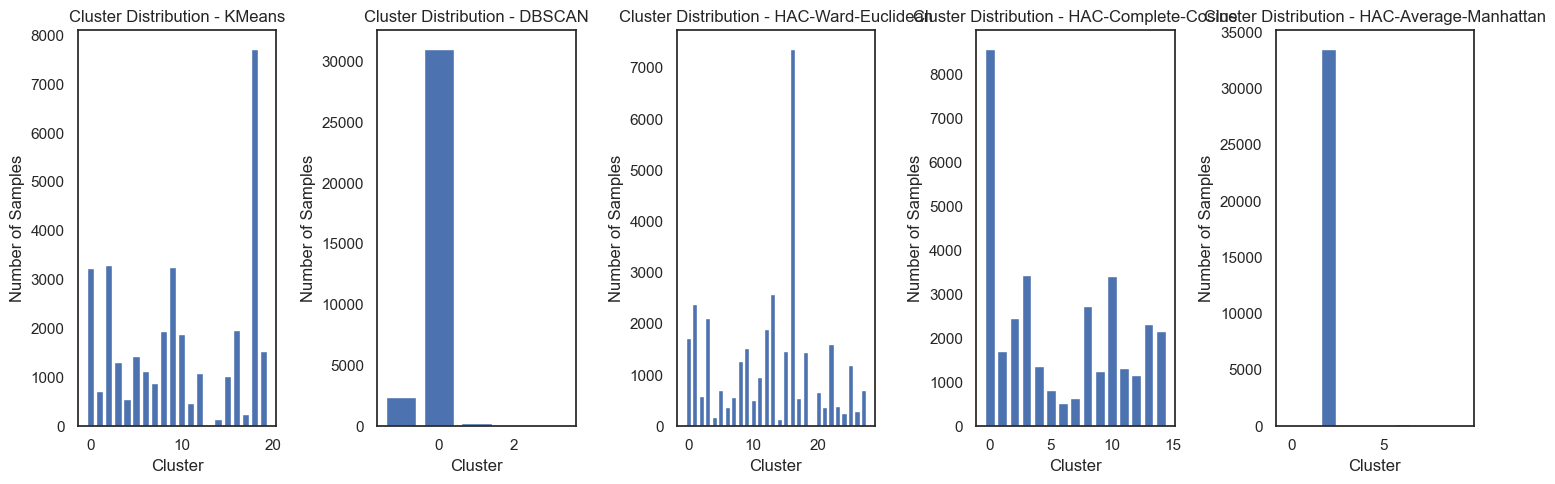

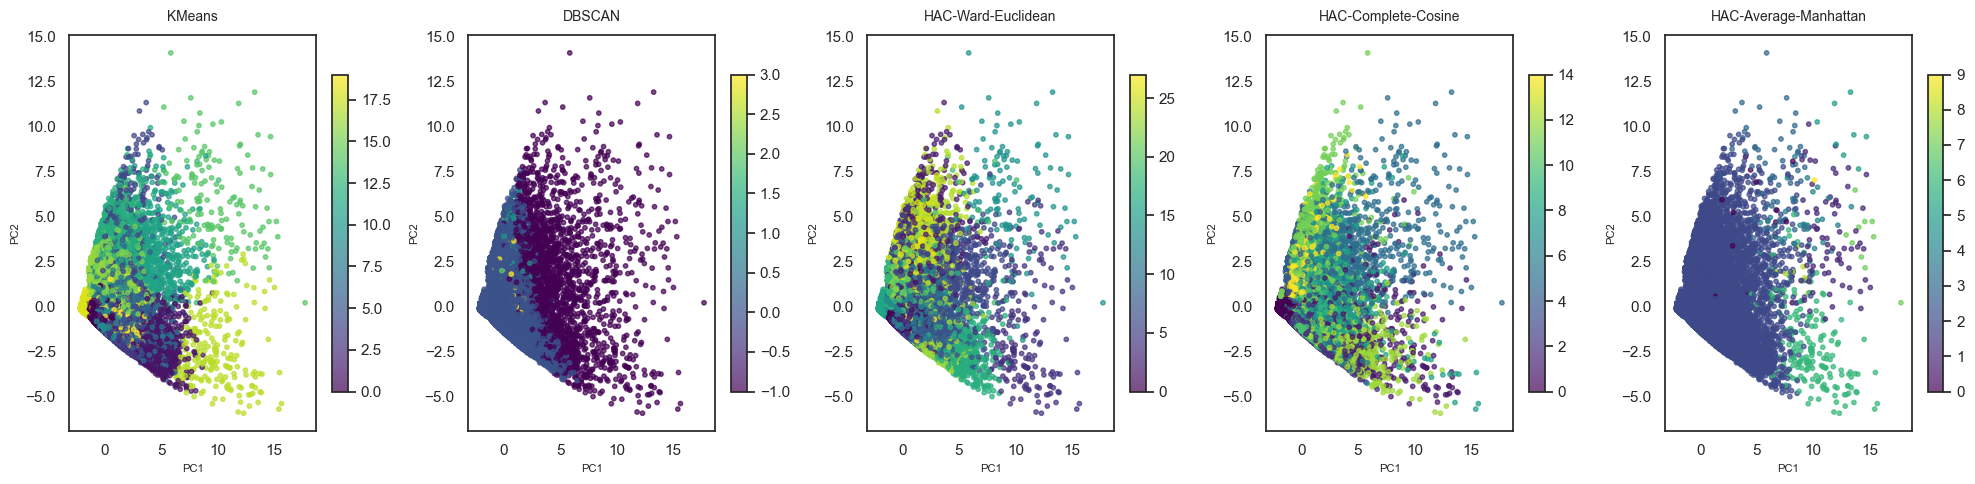

In [33]:
# get models
models = [
    kmeans_final,  # KMeans model
    best_dbscan,   # Best DBSCAN model
    best_model_we, # Ward Linkage Hierarchical
    best_model_cc, # Complete Linkage Hierarchical
    best_model_am  # Average Linkage Hierarchical
]

# model names
model_names = [
    'KMeans', 
    'DBSCAN', 
    'HAC-Ward-Euclidean', 
    'HAC-Complete-Cosine', 
    'HAC-Average-Manhattan'
]

# run analysis
detailed_results = detailed_clustering_analysis(
    features, 
    models, 
    model_names, 
)

**Measurements**

Silhouette Score {-1, 1}: Highest Score - 1, Measures how similar an object is to its own cluster

Calinski-Harabasz Index {higher better}: Ratio of between-cluster to within-cluster variance

Davies-Bouldin Index {lower better}: Best Score - 0.0, Average similarity between clusters

**K-Means Clustering:**

An okay silhouette score, the highest Calinski-Harabasz Index suggesting good cluster separation, and an okay Davies-Bouldin Index which shows moderate cluster overlap.

**DBSCAN:**

Lower clustering quality due to lower silhouette score. Lower cluster separation. Similar Davies-Bouldin Index to K-Means, suggesting slight overlap in clusters. From the cluster distributions, it is possible to notice that the clusters are very imbalanced and most users fit into one cluster. This would not be a great model to use.

**Hierarchical Clustering (Ward-Euclidean):**

A moderate clustering quality from its silhouette score. It has a good Calinski-Harabasz Index, suggesting good cluster separation. It does, however, have one of the highest cluster overlap, which is not great.

**Hierarchical Clustering (Complete-Cosine):**

This method, unsurprisingly has the lowest silhouette score (lowest clustering quality), which is expected as cosine is normally used for other tasks and not to separate this kind of data. It has moderate cluster separation and has the highest cluster overlap.

**Hierarchical Clustering (Average-Manhattan):**

This method has the highest clustering quality and the lowest cluster overlap. However, it has the lowest cluster separation and, similar to DBSCAN, it has one dominant cluster. This would not be a good method for the recommender system.

Following this analysis, the **k-means clustering** method seems to work best with our dataset.

#### Generating Recommendations For ALL Clustering Methods

Generating recommendations using KMeans...
Generating recommendations using DBSCAN...
Generating recommendations using HAC-Ward-Euclidean...
Generating recommendations using HAC-Complete-Cosine...
Generating recommendations using HAC-Average-Manhattan...

Recommendation Statistics by Model:
                model  total_recommendations  unique_users  avg_recommendations_per_user  recommendation_diversity
               DBSCAN                1053458         31003                     33.979228                  0.000032
HAC-Average-Manhattan                1271999         33493                     37.978055                  0.000030
  HAC-Complete-Cosine                  68381          8565                      7.983771                  0.000117
   HAC-Ward-Euclidean                  51408          7362                      6.982885                  0.000136
               KMeans                  61569          7715                      7.980428                  0.000130

Top 10 Recommende

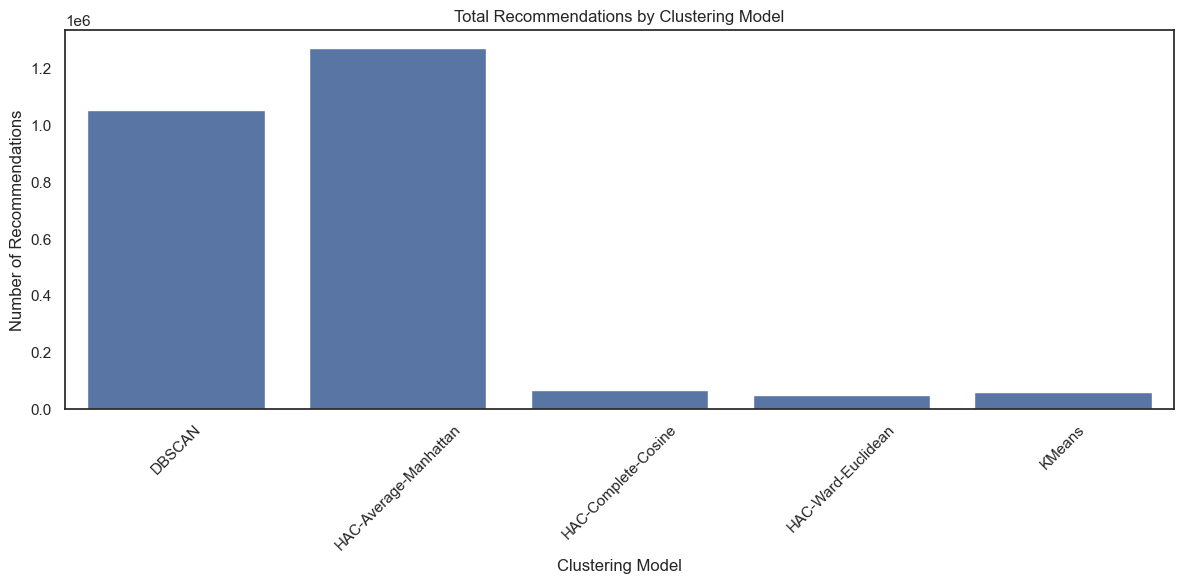

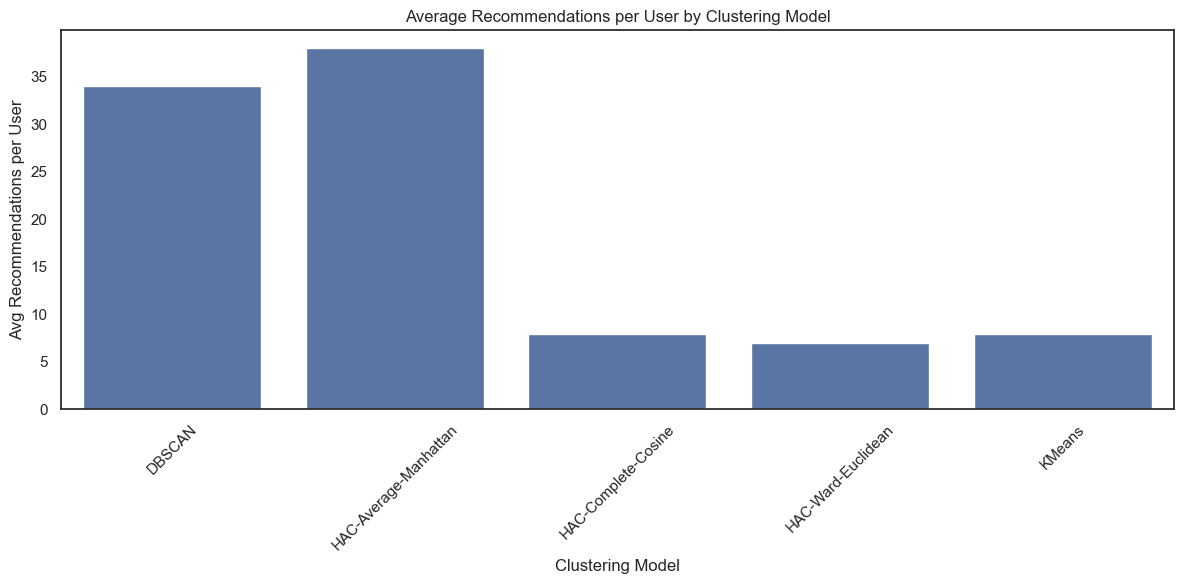

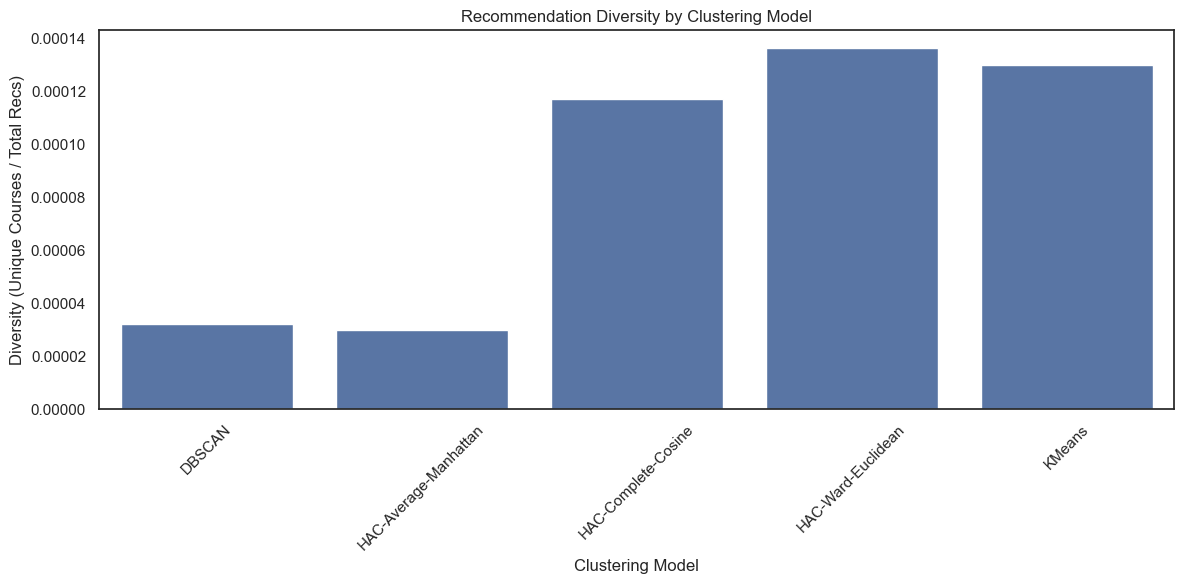

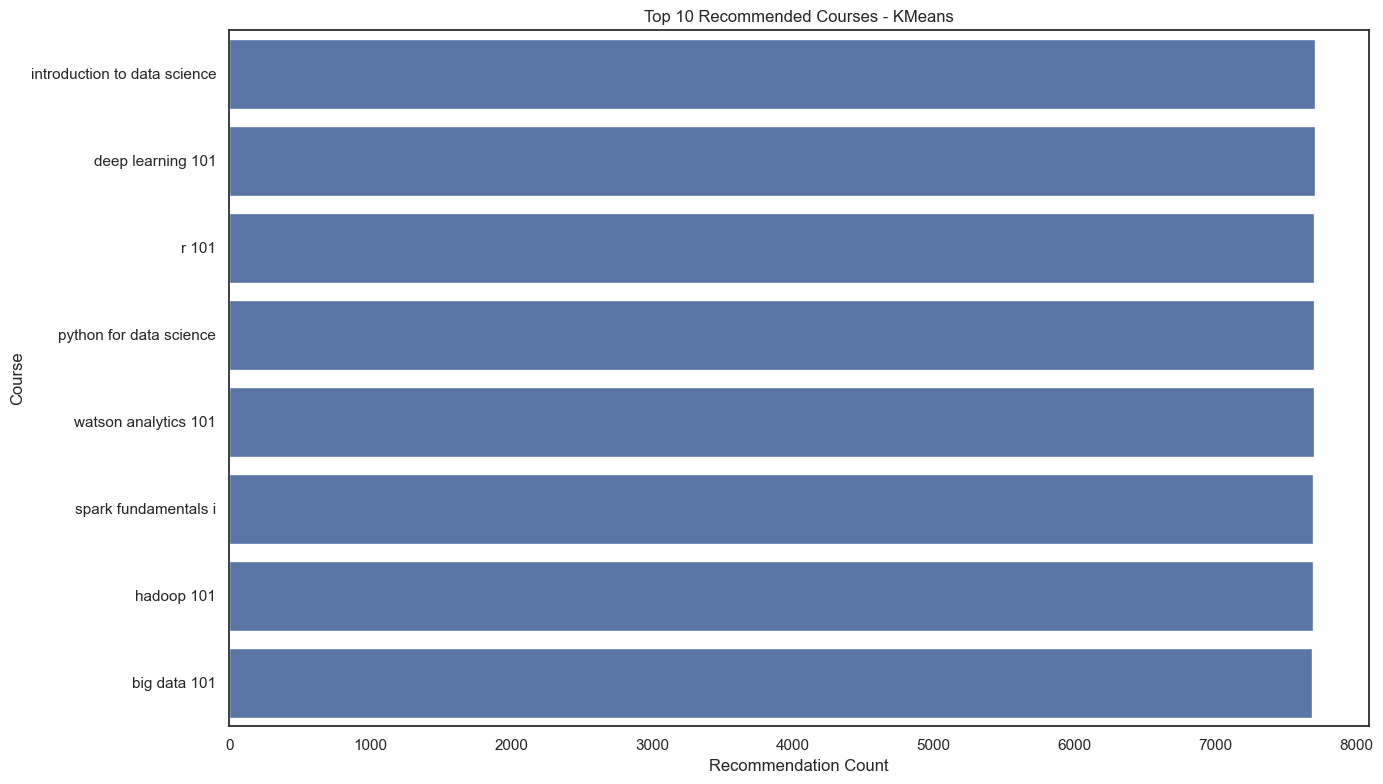

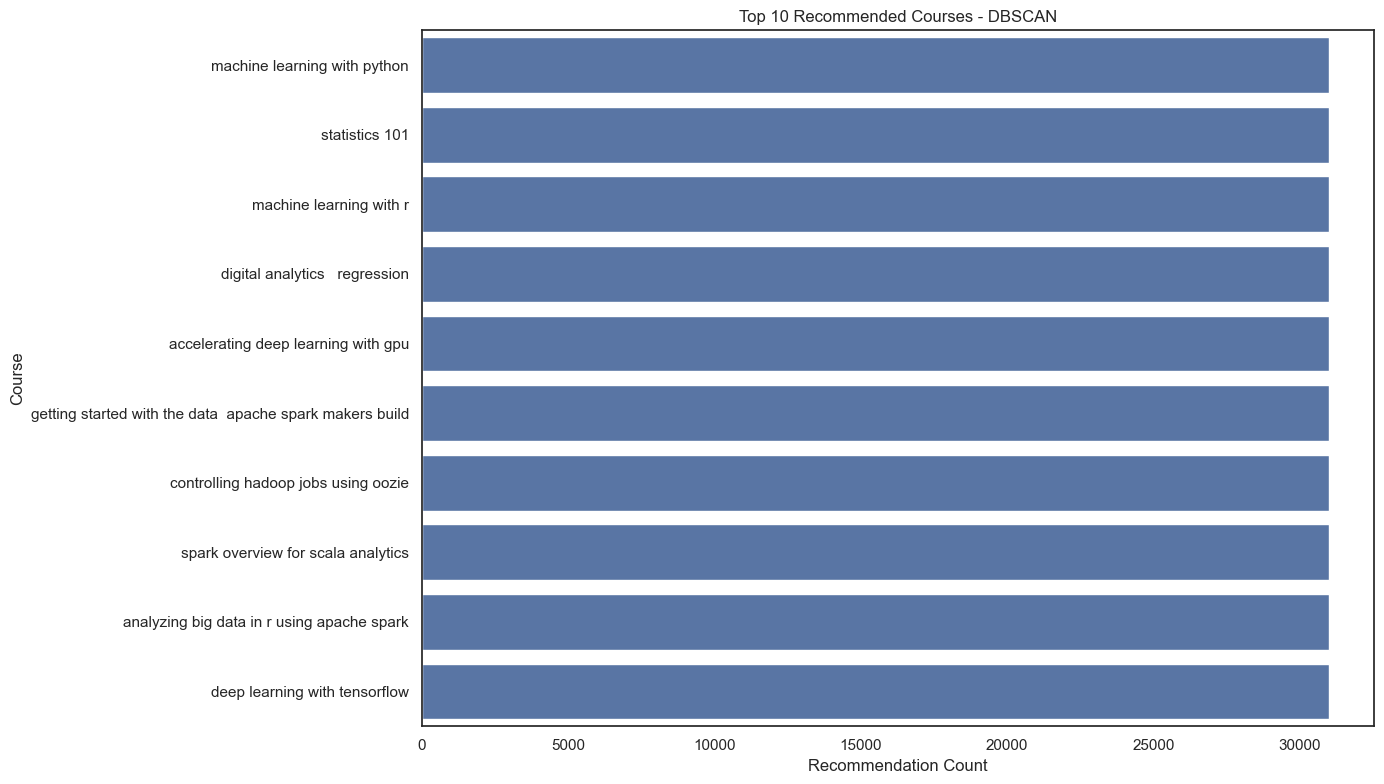

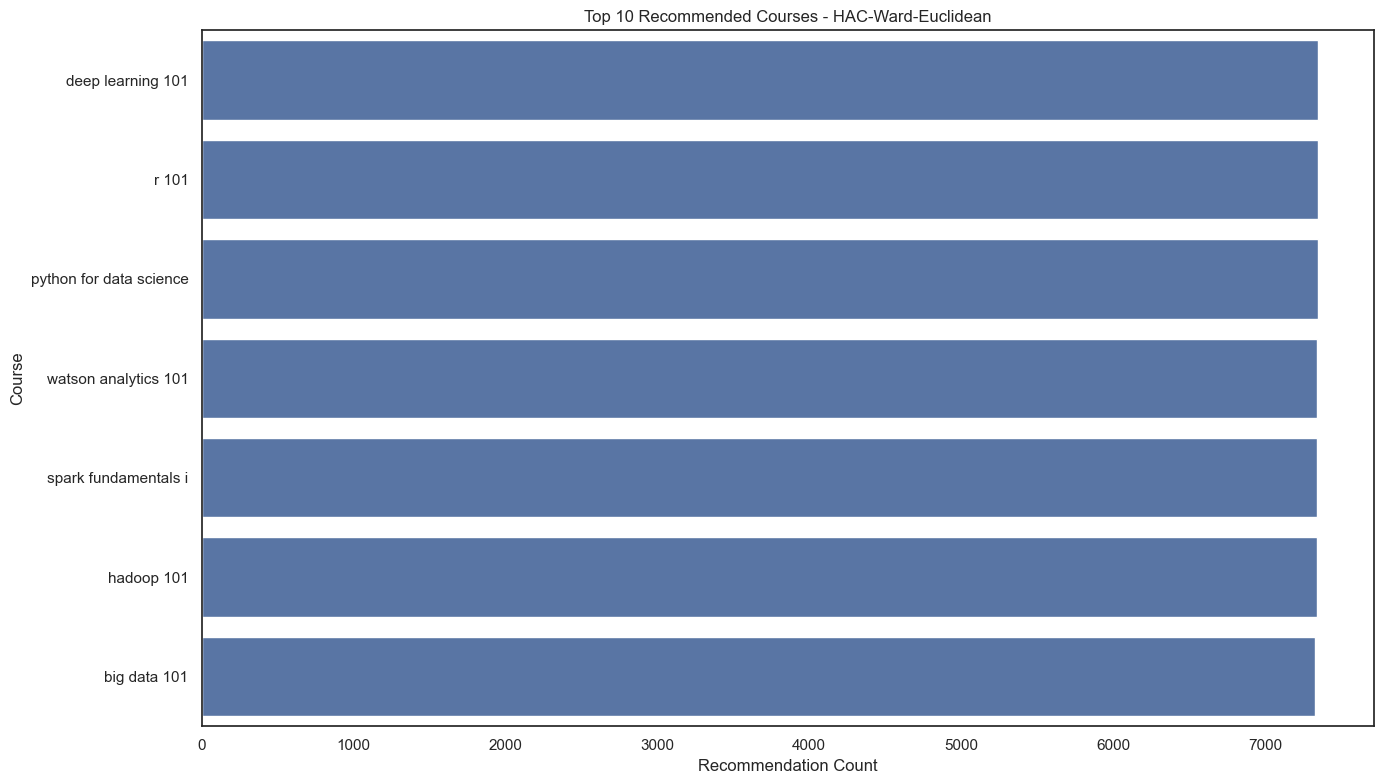

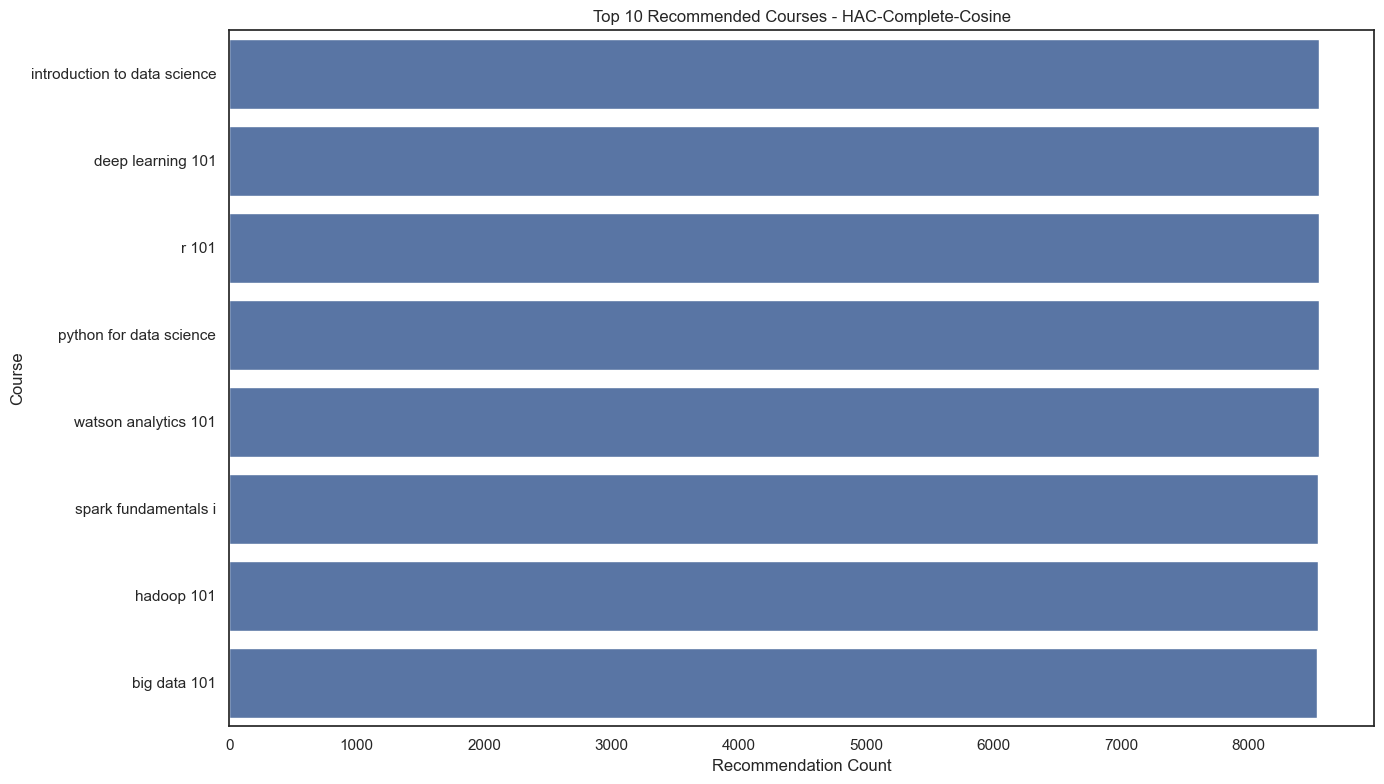

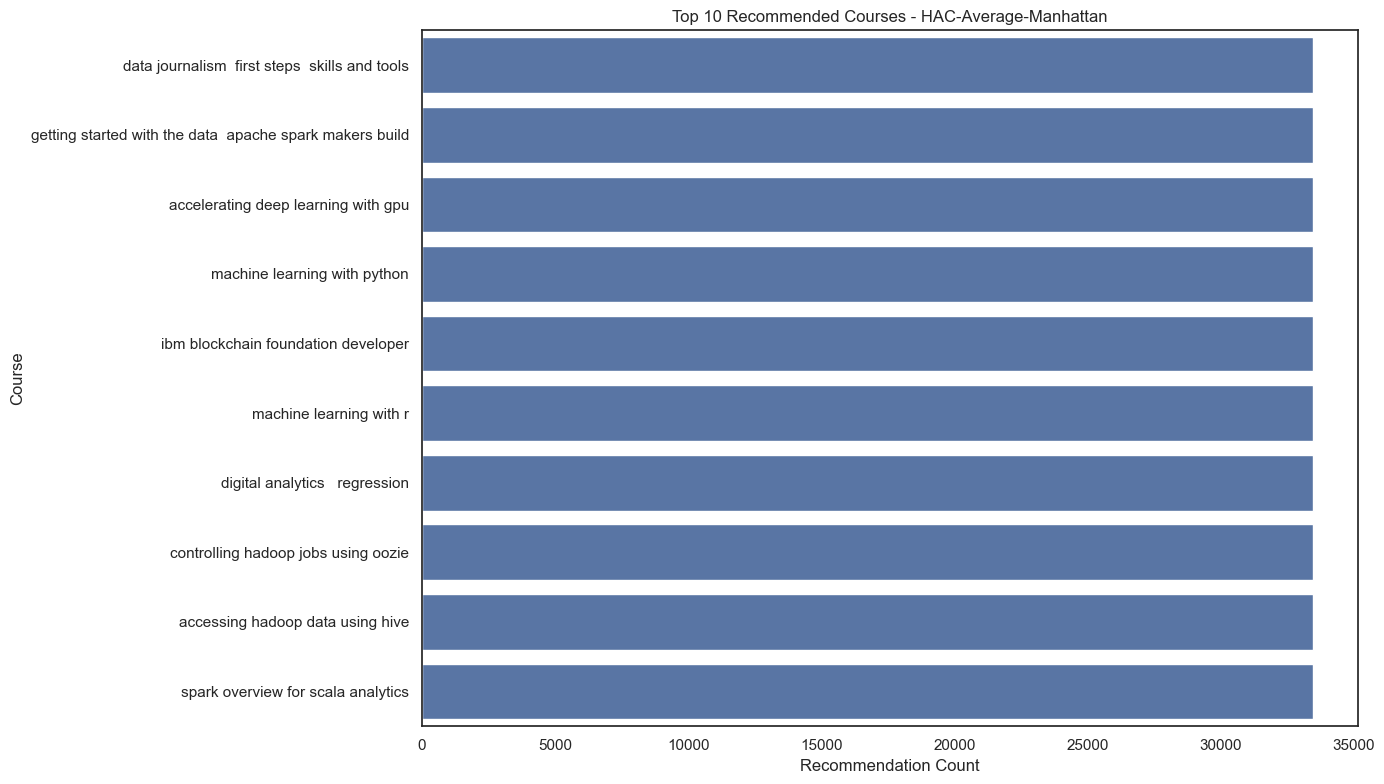

In [34]:

# generate recommendations based on a clustering model
def generate_cluster_recommendations(features, model, test_users_df, course_data, enrollment_threshold=10, model_name=None):
    # user ids
    user_ids = features.index.tolist()
    
    # cluster assignments
    if hasattr(model, 'predict'):
        # kmeans type
        cluster_labels = model.predict(features)
    elif hasattr(model, 'labels_'):
        # dbscan type
        cluster_labels = model.labels_
    else:
        raise ValueError("Model must have either predict method or labels_ attribute")
    
    # user cluster mapping
    user_clusters = pd.DataFrame({
        'user': user_ids,
        'cluster': cluster_labels
    })
    
    # merge
    test_users_labelled = pd.merge(test_users_df, user_clusters, on='user')
    
    # group by cluster and item
    courses_cluster_grouped = test_users_labelled.groupby(['cluster', 'item']).size().reset_index(name='enrollments')
    
    # recommendations
    recommendations_list = []
    
    for user in user_ids:
        # get cluster
        if user not in user_clusters['user'].values:
            continue  
            
        user_cluster = user_clusters[user_clusters['user'] == user]['cluster'].values[0]
        
        # skip users in noise cluster (-1) for DBSCAN
        if user_cluster == -1:
            continue
            
        # popular courses in cluster
        popular_cluster_courses = courses_cluster_grouped[
            (courses_cluster_grouped['cluster'] == user_cluster) & 
            (courses_cluster_grouped['enrollments'] >= enrollment_threshold)
        ]['item'].tolist()
        
        # enrolled courses
        user_enrolled_courses = test_users_df[test_users_df['user'] == user]['item'].tolist()
        
        # unseen popular courses
        unseen_popular_courses = [
            course for course in popular_cluster_courses 
            if course not in user_enrolled_courses
        ]
        
        # add to recommendations list
        for course in unseen_popular_courses:
            recommendations_list.append({
                'user': user,
                'course': course,
                'cluster': user_cluster,
                'model': model_name if model_name else 'Unknown'
            })
    
    # create recommendations DataFrame
    recommendations_df = pd.DataFrame(recommendations_list)
    
    return recommendations_df

# generate recommendations for all models
def generate_all_model_recommendations(features, models, model_names, test_users_df, course_data, enrollment_threshold=10):
    # all recs
    all_recommendations = []
    
    for model, model_name in zip(models, model_names):
        print(f"Generating recommendations using {model_name}...")
        model_recs = generate_cluster_recommendations(
            features, 
            model, 
            test_users_df, 
            course_data, 
            enrollment_threshold=enrollment_threshold,
            model_name=model_name
        )
        all_recommendations.append(model_recs)
    
    # combine all recommendations
    combined_recommendations = pd.concat(all_recommendations, ignore_index=True)
    
    return combined_recommendations

# analyze recommendations
def analyze_recommendations(recommendations_df, course_data):
    # course ids to titles
    if 'TITLE' in course_data.columns and 'COURSE_ID' in course_data.columns:
        course_titles = dict(zip(course_data['COURSE_ID'], course_data['TITLE']))
        recommendations_df['course_title'] = recommendations_df['course'].map(course_titles)
    
    # count recommendations per model
    model_counts = recommendations_df.groupby('model').size().reset_index(name='total_recommendations')
    
    # count unique users who received recommendations per model
    user_counts = recommendations_df.groupby('model')['user'].nunique().reset_index(name='unique_users')
    
    # calculate average recommendations per user for each model
    avg_recs = recommendations_df.groupby(['model', 'user']).size().reset_index(name='count')
    avg_per_user = avg_recs.groupby('model')['count'].mean().reset_index(name='avg_recommendations_per_user')
    
    # find top 10 most recommended courses for each model
    top_courses = {}
    for model in recommendations_df['model'].unique():
        model_df = recommendations_df[recommendations_df['model'] == model]
        course_counts = model_df['course'].value_counts().head(10)
        
        if 'course_title' in recommendations_df.columns:
            course_titles_list = []
            for course in course_counts.index:
                title_values = recommendations_df[recommendations_df['course'] == course]['course_title'].values
                if len(title_values) > 0:
                    course_titles_list.append(title_values[0])
                else:
                    course_titles_list.append("Unknown")
                    
            top_courses[model] = pd.DataFrame({
                'course': course_counts.index,
                'course_title': course_titles_list,
                'count': course_counts.values
            })
        else:
            top_courses[model] = pd.DataFrame({
                'course': course_counts.index,
                'count': course_counts.values
            })
    
    # combine statistics
    stats = pd.merge(model_counts, user_counts, on='model')
    stats = pd.merge(stats, avg_per_user, on='model')
    
    # calculate recommendation diversity (unique courses / total recommendations)
    unique_courses = recommendations_df.groupby('model')['course'].nunique()
    
    # create diversity Series with the same index as stats
    diversity = pd.Series(index=stats['model'])
    for model in stats['model']:
        if model in unique_courses.index and model in model_counts['model'].values:
            total_recs = model_counts.loc[model_counts['model'] == model, 'total_recommendations'].values[0]
            if total_recs > 0:
                diversity[model] = unique_courses[model] / total_recs
            else:
                diversity[model] = 0
        else:
            diversity[model] = 0
    
    # stats
    stats['recommendation_diversity'] = diversity.values
    
    return stats, top_courses

# visual comparison
def visualize_recommendation_comparison(stats, top_courses):
    # bar chart of recommendations per model
    plt.figure(figsize=(12, 6))
    sns.barplot(x='model', y='total_recommendations', data=stats)
    plt.title('Total Recommendations by Clustering Model')
    plt.xlabel('Clustering Model')
    plt.ylabel('Number of Recommendations')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # bar chart of average recommendations per user
    plt.figure(figsize=(12, 6))
    sns.barplot(x='model', y='avg_recommendations_per_user', data=stats)
    plt.title('Average Recommendations per User by Clustering Model')
    plt.xlabel('Clustering Model')
    plt.ylabel('Avg Recommendations per User')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # bar chart of recommendation diversity
    plt.figure(figsize=(12, 6))
    sns.barplot(x='model', y='recommendation_diversity', data=stats)
    plt.title('Recommendation Diversity by Clustering Model')
    plt.xlabel('Clustering Model')
    plt.ylabel('Diversity (Unique Courses / Total Recs)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # top courses visualization for each model
    for model, courses_df in top_courses.items():
        plt.figure(figsize=(14, 8))
        if 'course_title' in courses_df.columns:
            sns.barplot(x='count', y='course_title', data=courses_df)
            plt.title(f'Top 10 Recommended Courses - {model}')
        else:
            sns.barplot(x='count', y='course', data=courses_df)
            plt.title(f'Top 10 Recommended Courses - {model}')
        plt.xlabel('Recommendation Count')
        plt.ylabel('Course')
        plt.tight_layout()
        plt.show()
    
    return

# generate recs
all_recommendations = generate_all_model_recommendations(
    features, 
    models, 
    model_names, 
    test_users_df, 
    course_df,  
    enrollment_threshold=10
)

# analyse recs 
stats, top_courses = analyze_recommendations(all_recommendations, course_df)

# print summary statistics
print("\nRecommendation Statistics by Model:")
print(stats.to_string(index=False))

# print top 10 courses for each model
for model, courses_df in top_courses.items():
    print(f"\nTop 10 Recommended Courses - {model}:")
    print(courses_df.to_string(index=False))

# visual comparisons
visualize_recommendation_comparison(stats, top_courses)